## **Dataset and Model Overview**
**CIFAR-10 Dataset**

CIFAR-10 is a standard benchmark dataset widely used for image classification. It contains 60,000 RGB images of size 32×32 pixels, evenly distributed across 10 classes: Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, and Truck. The dataset is divided into 50,000 training images and 10,000 test images, with an equal number of samples per class. Despite its small image resolution, CIFAR-10 is a challenging dataset due to significant visual similarity between certain classes (e.g., cats and dogs), making it well-suited for evaluating convolutional neural network (CNN) models.
The original training set was further split into training and validation subsets to track model performance during training.

**Model Architecture**

The model implemented in this notebook is a convolutional neural network designed to learn hierarchical feature representations directly from raw pixel values. It consists of two convolutional layers for feature extraction, each followed by batch normalization and max pooling, and three fully connected layers for classification. Dropout with a rate of 30% is applied in the fully connected layers to reduce overfitting. Non-linear activation functions are used throughout the network to enable learning of complex decision boundaries. The model is trained using cross-entropy loss and optimized with the Adam optimizer.

**Data Augmentation and Preprocessing**

To improve generalization and reduce overfitting, data augmentation was applied to the training set only. The following transformations were used:

*   Random cropping with padding to introduce small spatial variations
*   Random horizontal flipping to simulate viewpoint changes
*   Normalization using dataset-specific mean and standard deviation

These transformations increased the diversity of the training data while preserving the semantic content of the images. For the validation and test sets, only tensor conversion and normalization were applied to ensure consistent and unbiased evaluation.

**Summary**

By combining a straightforward CNN architecture with appropriate data augmentation techniques, the model achieved a accuracy of approximately 74% on a held out test set. This approach provides a solid baseline and a strong foundation for further experimentation and architectural improvements.

**Importing necessary libraries**

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

**Mean and Standard Deviation of CIFAR-10 Dataset**

In [17]:
mean=[0.4914, 0.4822, 0.4465]
std= [0.2471, 0.2435, 0.2616]

**Augmentations for Train and Test Data**

In [18]:
train_transform = transforms.Compose([
    # transforms.Resize(224), # Resize 32x32 to 224x224
    #Add 4 pixels of padding on each side, then crop back to 32x32
    transforms.RandomCrop(32, padding=4),
    #Flip horizontally with a default 50% probability
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std= std), # calculated mean and std for dataset

])

test_transform = transforms.Compose([
    # transforms.Resize(224), # Resize 32x32 to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std= std) # calculated mean and std for dataset
])

**Train, Val and Test Dataset**

In [20]:
batch_size = 32
trainset_full = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)

valset_full = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=False,          # already downloaded
    transform=test_transform # NO augmentation
)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

In [21]:
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

In [22]:
# # Generate indices for the split
# train_idx, val_idx = train_test_split(list(range(len(trainset))), test_size=0.1, random_state=42)
# #list(range(len(trainset))) gives the index of 50000 images in the trainset

indices = list(range(len(trainset_full)))
train_idx, val_idx = train_test_split(
    indices, test_size=0.1, random_state=42
)

# Create Subsets
train_subset = Subset(trainset_full, train_idx)
val_subset   = Subset(valset_full, val_idx)

# Define Loaders
trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

**Plotting Sample Images from Train Dataset**

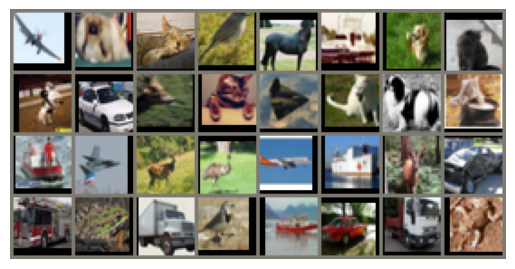

Airplane Dog   Cat   Bird  Horse Ship  Dog   Cat   Horse Automobile Deer  Cat   Airplane Cat   Dog   Cat   Ship  Airplane Deer  Bird  Airplane Ship  Deer  Automobile Truck Frog  Truck Bird  Ship  Automobile Truck Frog 


In [23]:
#Plot the first 32 images in training set
def imshow(img):
    # Define your specific mean and std
    mean_t = torch.tensor(mean).view(3, 1, 1)
    std_t = torch.tensor(std).view(3, 1, 1)

    # Unnormalize: (img * std) + mean
    img = img * std_t + mean_t

    # Clip values to ensure they stay between 0 and 1 for matplotlib
    img = torch.clamp(img, 0, 1)

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))#pytorch(C,W,H) -> matplotlib(H,W,C)
    plt.axis('off') # Hide axes for a cleaner look
    plt.show()

# Get a batch and show
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

**CNN Model**

In [24]:
#Define CNN model
#Feature Extractor - 2 Conv layers along with BatchNorm and MaxPool
#Feature Classifier  - 2 FC layers
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()

        self.feature_extractor = nn.Sequential(
            # Layer 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # Batch Norm after Conv
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Layer 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), # Batch Norm after Conv
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten()
        )

        self.classifier = nn.Sequential(
            nn.Linear(64 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_model().to(device)

In [27]:
#Define Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

**Train and Test Loops**

In [28]:
# Initialize lists to store metrics manually
history = {
    "train_loss": [], "val_loss": [],
    "train_acc": [], "val_acc": []
}

epochs = 10

for epoch in range(epochs):
    # --- TRAINING PHASE ---
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    avg_train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct_train / total_train

    # --- VALIDATION PHASE ---
    model.eval()
    running_val_loss, correct_val, total_val = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            _, predicted_val = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    avg_val_loss = running_val_loss / len(valloader)
    val_accuracy = 100 * correct_val / total_val

    # Store metrics in our history dictionary
    history["train_loss"].append(avg_train_loss)
    history["val_loss"].append(avg_val_loss)
    history["train_acc"].append(train_accuracy)
    history["val_acc"].append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.3f}, Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {avg_val_loss:.3f}, Acc: {val_accuracy:.2f}%")

Epoch 1/10 | Train Loss: 1.602, Acc: 41.15% | Val Loss: 1.234, Acc: 55.40%
Epoch 2/10 | Train Loss: 1.329, Acc: 51.91% | Val Loss: 1.068, Acc: 60.72%
Epoch 3/10 | Train Loss: 1.215, Acc: 56.49% | Val Loss: 0.994, Acc: 63.90%
Epoch 4/10 | Train Loss: 1.143, Acc: 59.69% | Val Loss: 0.933, Acc: 66.22%
Epoch 5/10 | Train Loss: 1.100, Acc: 60.85% | Val Loss: 0.921, Acc: 67.10%
Epoch 6/10 | Train Loss: 1.055, Acc: 62.65% | Val Loss: 0.861, Acc: 69.10%
Epoch 7/10 | Train Loss: 1.026, Acc: 63.96% | Val Loss: 0.860, Acc: 69.10%
Epoch 8/10 | Train Loss: 0.995, Acc: 65.17% | Val Loss: 0.848, Acc: 70.20%
Epoch 9/10 | Train Loss: 0.973, Acc: 66.03% | Val Loss: 0.806, Acc: 71.38%
Epoch 10/10 | Train Loss: 0.949, Acc: 66.84% | Val Loss: 0.762, Acc: 73.54%


**Visualizations**

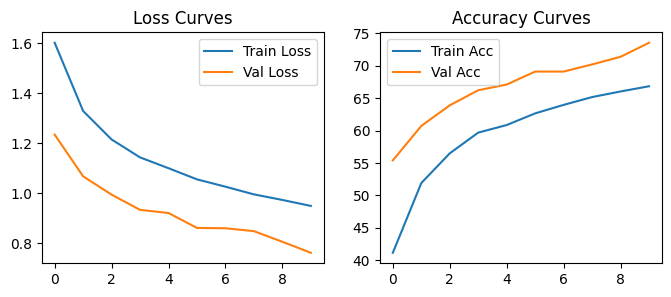

In [29]:
# --- POST-TRAINING VISUALIZATION ---

# Plot Training & Validation Curves
plt.figure(figsize=(8, 3))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label='Train Loss')
plt.plot(history["val_loss"], label='Val Loss')
plt.title('Loss Curves')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label='Train Acc')
plt.plot(history["val_acc"], label='Val Acc')
plt.title('Accuracy Curves')
plt.legend()
plt.show()

Evaluation on Test Set

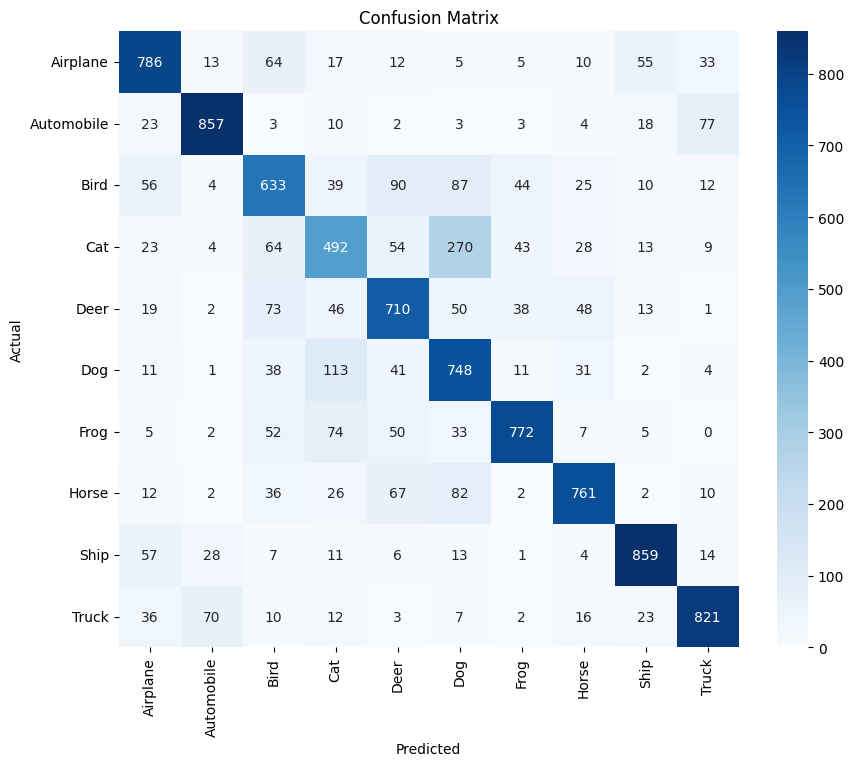


--- Final Classification Report ---
              precision    recall  f1-score   support

    Airplane       0.76      0.79      0.78      1000
  Automobile       0.87      0.86      0.86      1000
        Bird       0.65      0.63      0.64      1000
         Cat       0.59      0.49      0.53      1000
        Deer       0.69      0.71      0.70      1000
         Dog       0.58      0.75      0.65      1000
        Frog       0.84      0.77      0.80      1000
       Horse       0.81      0.76      0.79      1000
        Ship       0.86      0.86      0.86      1000
       Truck       0.84      0.82      0.83      1000

    accuracy                           0.74     10000
   macro avg       0.75      0.74      0.74     10000
weighted avg       0.75      0.74      0.74     10000



In [30]:
# 4. Final Evaluation on Test Set
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 5. Display Confusion Matrix Heatmap
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 6. Print Classification Report
print("\n--- Final Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=classes))